# Customer Segmentation with k-Prototypes Clustering

We will use a clustering based approach to group customers into segments.

This is a form of unsupervised learning. 

The purpose of customer segmentation is to understand our customer base better, and can be used as an exploratory starting point before further analysis.

# k-Prototypes Clustering

k-prototypes is a more general version of the popular k-means clustering.

k-means clustering aims to cluster data points such that we minimize the sum of squared distances between each data point and its cluster's centroid. It only applies to continuous variables.

k-modes clustering aims to cluster **categorical** data points such that we minimize the number of mismatches between each data point and its cluster's centroid. 

In k-prototypes clustering, we use k-means clustering for the continuous variables, but we use k-modes clustering for categorical variables. Therefore, we use a combined dissimilarity metric (sum of squared distance for continuous variables, and the mismatch count for the categorical variable to assign each data point to a cluster)

In [1]:
import importlib
import pandas as pd
import utils

#include k-means explanation above

In [2]:
importlib.reload(utils)

<module 'utils' from '/Users/nicolearitranair/Projects/ml-basics/notebook/utils.py'>

In [3]:
import numpy as np

df = utils.get_customer_segmentation_data()
df

,Customer_ID,Age,Gender,CreditScore,Tenure,Balance,Education,HasTravelCard,HasCashBackCard,HasPointsCard,HasRewardsCard,HasSecuredCard,Transaction_Count,Avg_Transaction_Value,EstimatedSalary
2,3,61,M,783,9,199491.201077,6,1,1,0,0,1,4,441.175702,140656.487031
544,545,69,M,817,9,195704.837129,6,1,0,1,1,1,4,401.790615,146999.861232
2,3,50,M,823,6,117320.317523,5,1,0,0,1,0,4,288.636668,104856.651352
414,415,49,F,835,6,137855.925347,4,1,1,1,1,1,4,172.867269,111643.458117
188,189,66,M,845,9,194538.137261,6,1,1,1,0,0,4,486.863710,145782.287605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
817,818,20,M,349,0,7907.641657,1,0,1,0,1,0,1,43.961959,49491.947673
546,547,60,M,805,9,197233.837333,6,1,1,1,0,0,4,470.724628,149301.223424
382,383,64,M,785,9,194796.772163,6,1,1,1,0,1,4,424.849898,147704.689900
177,178,21,M,387,0,8807.698100,1,1,1,1,0,0,1,36.517452,28149.610568


In [4]:
df.to_csv("output_data/customer-segmentation-data.csv", index=False)

In [5]:
df

,Customer_ID,Age,Gender,CreditScore,Tenure,Balance,Education,HasTravelCard,HasCashBackCard,HasPointsCard,HasRewardsCard,HasSecuredCard,Transaction_Count,Avg_Transaction_Value,EstimatedSalary
2,3,61,M,783,9,199491.201077,6,1,1,0,0,1,4,441.175702,140656.487031
544,545,69,M,817,9,195704.837129,6,1,0,1,1,1,4,401.790615,146999.861232
2,3,50,M,823,6,117320.317523,5,1,0,0,1,0,4,288.636668,104856.651352
414,415,49,F,835,6,137855.925347,4,1,1,1,1,1,4,172.867269,111643.458117
188,189,66,M,845,9,194538.137261,6,1,1,1,0,0,4,486.863710,145782.287605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
817,818,20,M,349,0,7907.641657,1,0,1,0,1,0,1,43.961959,49491.947673
546,547,60,M,805,9,197233.837333,6,1,1,1,0,0,4,470.724628,149301.223424
382,383,64,M,785,9,194796.772163,6,1,1,1,0,1,4,424.849898,147704.689900
177,178,21,M,387,0,8807.698100,1,1,1,1,0,0,1,36.517452,28149.610568


# Normalizing the input data

We use min-max normalization on all the continuous features in the input data. 

The purpose of min-max normalization is to ensure that features with "larger" ranges do not dominate the clustering process compared to features with "smaller" ranges.

For example, "Balance" might have a much larger range than "Age" so we want to control for this.

In [6]:
df_to_cluster_normalize  = df.iloc[:,1:].copy()

continuous_columns = ["Age", "CreditScore", "Tenure", "Balance", "Transaction_Count", "Avg_Transaction_Value", "EstimatedSalary"]
mins_dict = {}
maxes_dict = {}

for col in continuous_columns:
    print(col)
    #rescale the continuous data
    mins_dict[col] = df_to_cluster_normalize[col].min()
    maxes_dict[col] = df_to_cluster_normalize[col].max()
    df_to_cluster_normalize[col] = (df_to_cluster_normalize[col]-df_to_cluster_normalize[col].min())/(df_to_cluster_normalize[col].max()-df_to_cluster_normalize[col].min())

Age
CreditScore
Tenure
Balance
Transaction_Count
Avg_Transaction_Value
EstimatedSalary


# Determine an appropriate number of clusters

Since we are not sure of how the customers should be segmented, we can first use the Elbow Method to determine an appropriate number of clusters.

In the Elbow Method, we will calculate
- within-cluster sum of squares (compared to centroid) for continuous variables
- total number of category mismatches with centroid for the categorical variables

Logically, we will always observe a decrease in the cost, and we want to find the "elbow" point in cost reduction that tells us to stop increasing clusters.

In the plot below, we can see that it clearly occurs at 3 clusters.

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 0, ncost: 5047.088928098004
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 0, ncost: 5047.088928098004
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 0, ncost: 5047.088928098004
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 0, ncost: 5047.088928098004
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 5, iteration: 1/100, moves: 0, ncost: 5047.088928098004
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 6, ncost: 2069.7289857351216
Run: 1, iteration: 2/100, moves: 0, ncost: 2069.7289857351216
Init: initializing centroids
Init: initializing clusters
Starting ite

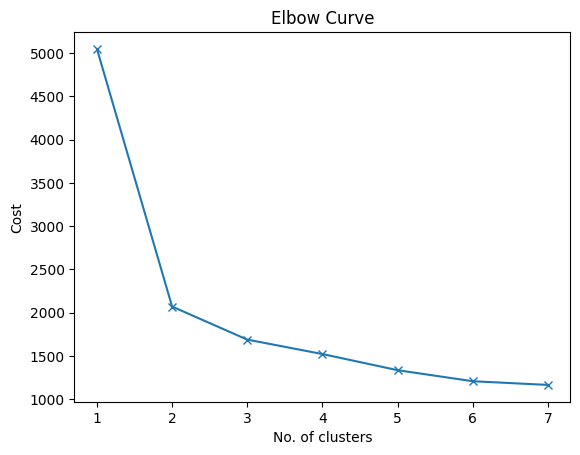

In [7]:
from kmodes.kprototypes import KPrototypes
import matplotlib.pyplot as plt
# Elbow curve to find optimal K 

cost = [] 
kmode_models = []
K = [1, 2, 3, 4, 5, 6, 7]
for k in list(K): 
    kmode = KPrototypes(n_clusters=k, init = "random", n_init = 5, verbose=1) 
    kmode.fit_predict(df_to_cluster_normalize, categorical=[1, 5, 6, 7, 8, 9, 10]) 
    cost.append(kmode.cost_)
    kmode_models.append(kmode)
      
plt.plot(K, cost, 'x-') 
plt.xlabel('No. of clusters') 
plt.ylabel('Cost') 
plt.title('Elbow Curve') 
plt.show()

In [8]:
from kmodes.kprototypes import KPrototypes

kmode = KPrototypes(n_clusters=3, init = "random", n_init = 5, verbose=1, random_state=12345) 
kmode.fit_predict(df_to_cluster_normalize, categorical=[1, 5, 6, 7, 8, 9, 10]) 

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 220, ncost: 1888.0878966702533
Run: 1, iteration: 2/100, moves: 96, ncost: 1887.9782337167367
Run: 1, iteration: 3/100, moves: 9, ncost: 1887.975676708645
Run: 1, iteration: 4/100, moves: 3, ncost: 1887.9754867700635
Run: 1, iteration: 5/100, moves: 0, ncost: 1887.9754867700635
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 267, ncost: 1708.5299368075441
Run: 2, iteration: 2/100, moves: 85, ncost: 1695.7562787143352
Run: 2, iteration: 3/100, moves: 70, ncost: 1687.8040807123625
Run: 2, iteration: 4/100, moves: 14, ncost: 1687.7483286923527
Run: 2, iteration: 5/100, moves: 3, ncost: 1687.7448832295795
Run: 2, iteration: 6/100, moves: 0, ncost: 1687.7448832295795
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 1123, ncost: 1753.0116200145158
Run: 3

array([2, 2, 1, ..., 2, 0, 2], dtype=uint16)

In [9]:
df_to_cluster_normalize["Label"] = kmode.labels_
df["Label"] = kmode.labels_

In [10]:
kmode.cluster_centroids_

array([['0.06050980392156915', '0.09030054644808747',
        '0.05733333333333395', '0.02508134563896045', '0.0',
        '0.031912484874657546', '0.11561366771782199', 'F', '1', '0',
        '1', '0', '0', '0'],
       ['0.56827295890107', '0.9545141140028626', '0.6107972379158718',
        '0.6210217533877572', '1.0', '0.37429718092949077',
        '0.8066160310650826', 'F', '5', '0', '0', '0', '1', '1'],
       ['0.8766200650663892', '0.9129832471595304', '0.9604384653712061',
        '0.9403055532523306', '1.0', '0.8443716155051431',
        '0.9473860110229465', 'M', '6', '1', '1', '1', '1', '0']],
      dtype='<U32')

# Analyzing the customer segments

First, let's look at the categorical variables.

We can see that cluster 0 is made of a femal majority, with a medium level of education and who tend to not have credit cards. 

Cluster 1 is made up of a male majority, with a low level of education and who tend to not have credit cards.

Cluster 2 is made up of a highly educated male majority who tend to have credit cards.

In [11]:
df_to_cluster_normalize.columns

Index(['Age', 'Gender', 'CreditScore', 'Tenure', 'Balance', 'Education',
       'HasTravelCard', 'HasCashBackCard', 'HasPointsCard', 'HasRewardsCard',
       'HasSecuredCard', 'Transaction_Count', 'Avg_Transaction_Value',
       'EstimatedSalary', 'Label'],
      dtype='object')

# Cluster Profile

Let's look in more detail at the profiles of each of the 3 clusters

In [12]:
def visualize_cluster(cluster_idx):
    gender_vc = df_to_cluster_normalize[df_to_cluster_normalize["Label"]==cluster_idx]["Gender"].value_counts()
    education_vc = df_to_cluster_normalize[df_to_cluster_normalize["Label"]==cluster_idx]["Education"].value_counts()
    has_tc_vc = df_to_cluster_normalize[df_to_cluster_normalize["Label"]==cluster_idx]["HasTravelCard"].value_counts()
    has_cc_vc = df_to_cluster_normalize[df_to_cluster_normalize["Label"]==cluster_idx]["HasCashBackCard"].value_counts()
    has_pc_vc = df_to_cluster_normalize[df_to_cluster_normalize["Label"]==cluster_idx]["HasPointsCard"].value_counts()
    has_rc_vc = df_to_cluster_normalize[df_to_cluster_normalize["Label"]==cluster_idx]["HasRewardsCard"].value_counts()
    has_sc_vc = df_to_cluster_normalize[df_to_cluster_normalize["Label"]==cluster_idx]["HasSecuredCard"].value_counts()    

    plt.figure(figsize=(20, 20))

    plt.subplot(4, 4, 1)
    plt.bar(gender_vc.index, gender_vc)
    plt.title("Gender")


    plt.subplot(4, 4, 2)
    plt.bar(education_vc.index, education_vc)
    plt.title("Education")


    plt.subplot(4, 4, 3)
    plt.bar(has_tc_vc.index, has_tc_vc)
    plt.title("Has Travel Card")


    plt.subplot(4, 4, 4)
    plt.bar(has_cc_vc.index, has_cc_vc)
    plt.title("Has Cashback Card")


    plt.subplot(4, 4, 5)
    plt.bar(has_pc_vc.index, has_pc_vc)
    plt.title("Has Points Card")


    plt.subplot(4, 4, 6)
    plt.bar(has_rc_vc.index, has_rc_vc)
    plt.title("Has Rewards Card")


    plt.subplot(4, 4, 7)
    plt.bar(has_sc_vc.index, has_sc_vc)
    plt.title("Has Secured Card")

    c = 8
    for x in continuous_columns:
        plt.subplot(4, 4, c)
        plt.hist(df[df["Label"]==cluster_idx][x])
        plt.title(x)
        c+=1

    plt.show()

# Cluster 0: Young Penny Pinchers

- This group of customers are dealing with relatively low incomes and savings
- They disproportionately choose to purchase the cashback card which may indicate that this product should be recommended to new customers within this demographic as well.
- They haven't been with the bank very long, which is not too surprising given their age
- They have moderate interest in other types of credit cards as well.
- They have relatively low credit scores, indicating that they may be looking to improve it.

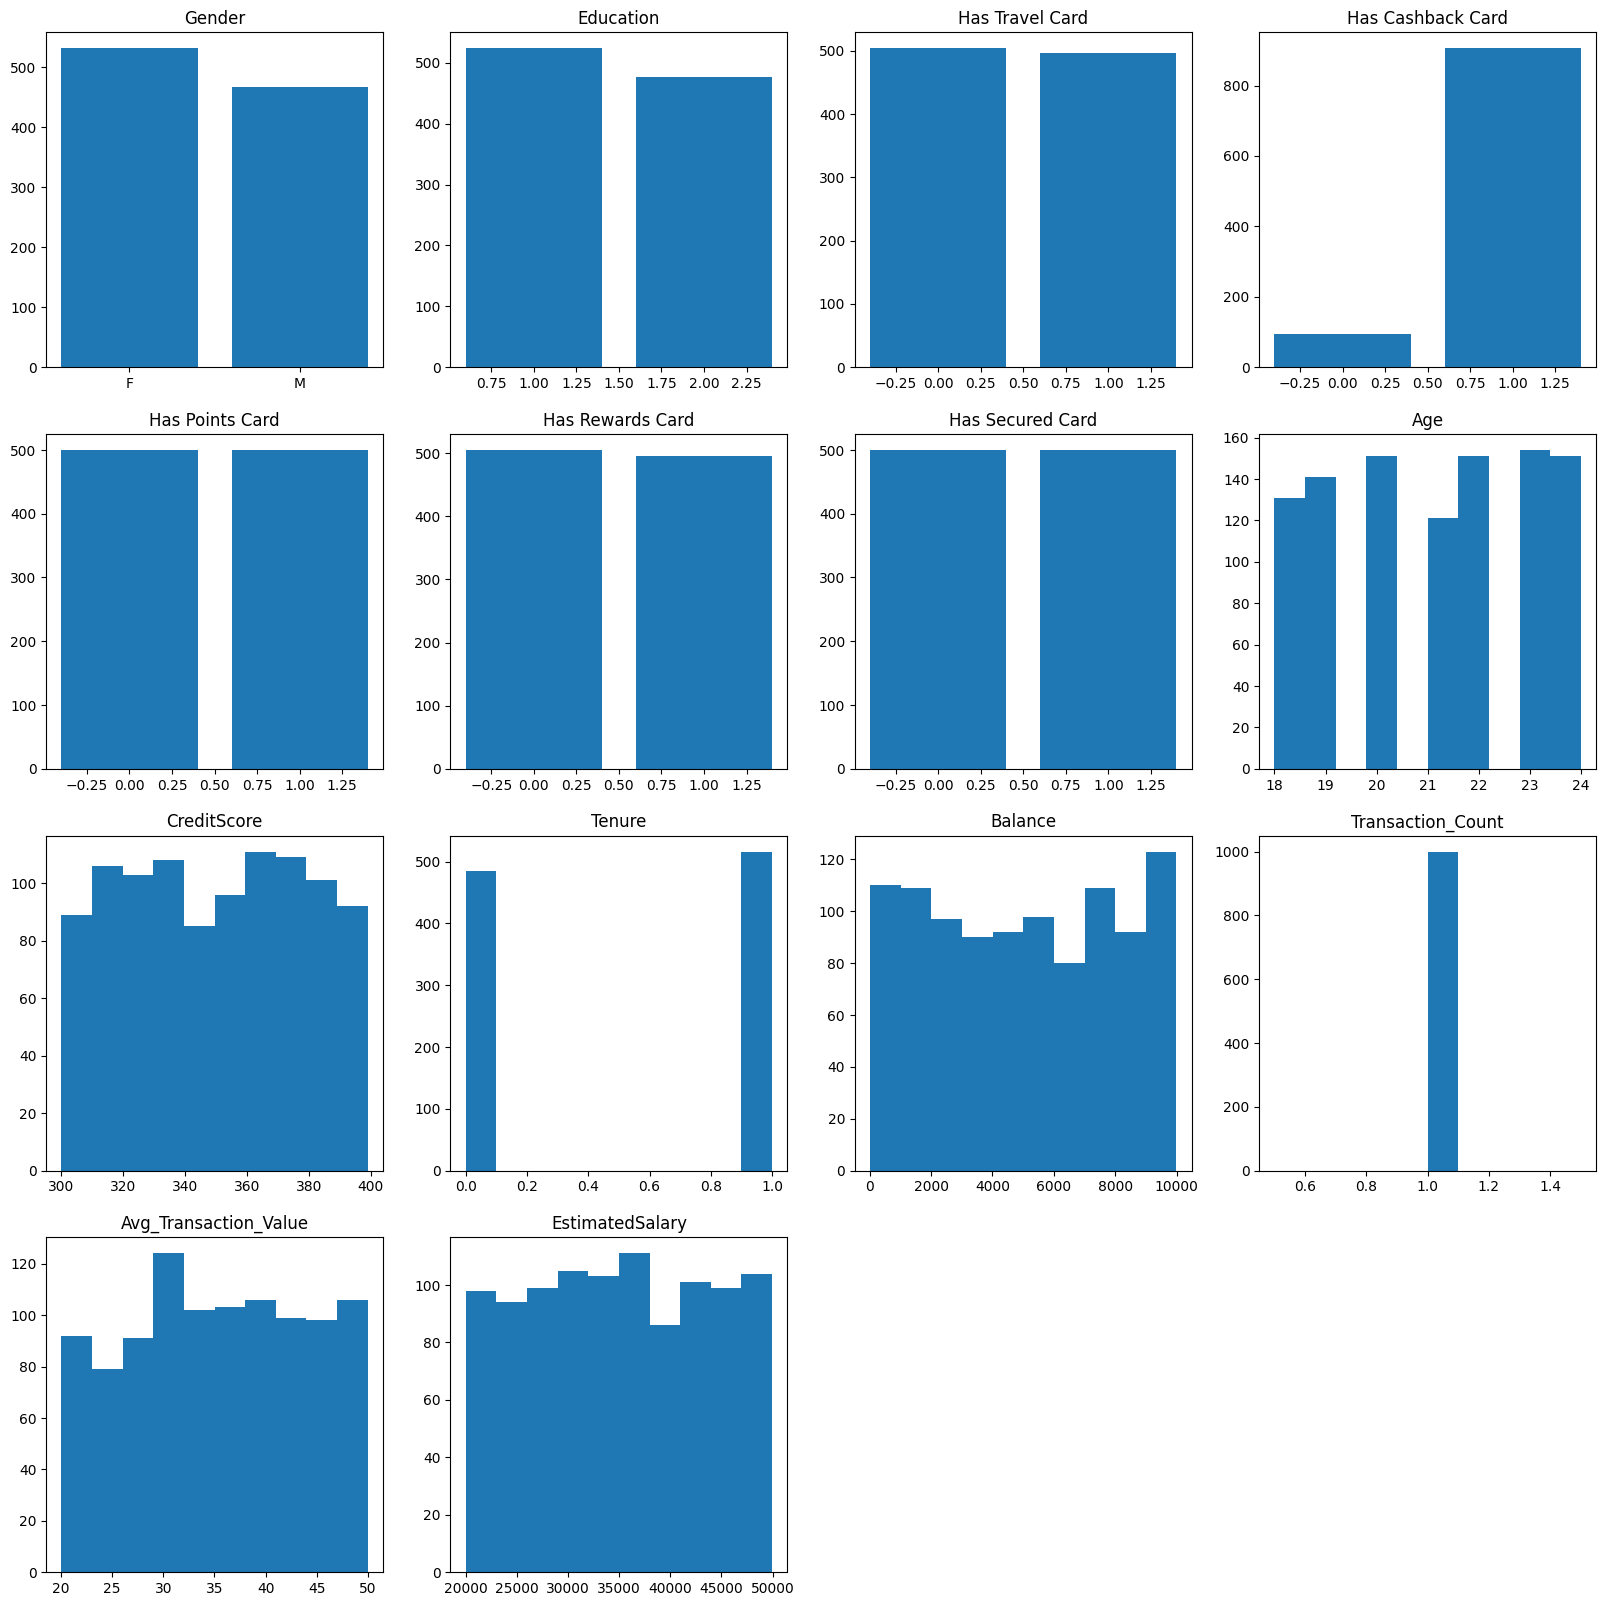

In [13]:
visualize_cluster(0)

# Cluster 1: Comfortable Cruisers
- Members of this cluster tend to be middle aged with comfortable incomes and moderate to high spending power.
- They disproportionately enjoy rewards cards which may indicate that they are big on lifestyle and culture
- Due to being middle aged, with relatively long tenure, they potentially bring lots more value to the bank in the future.

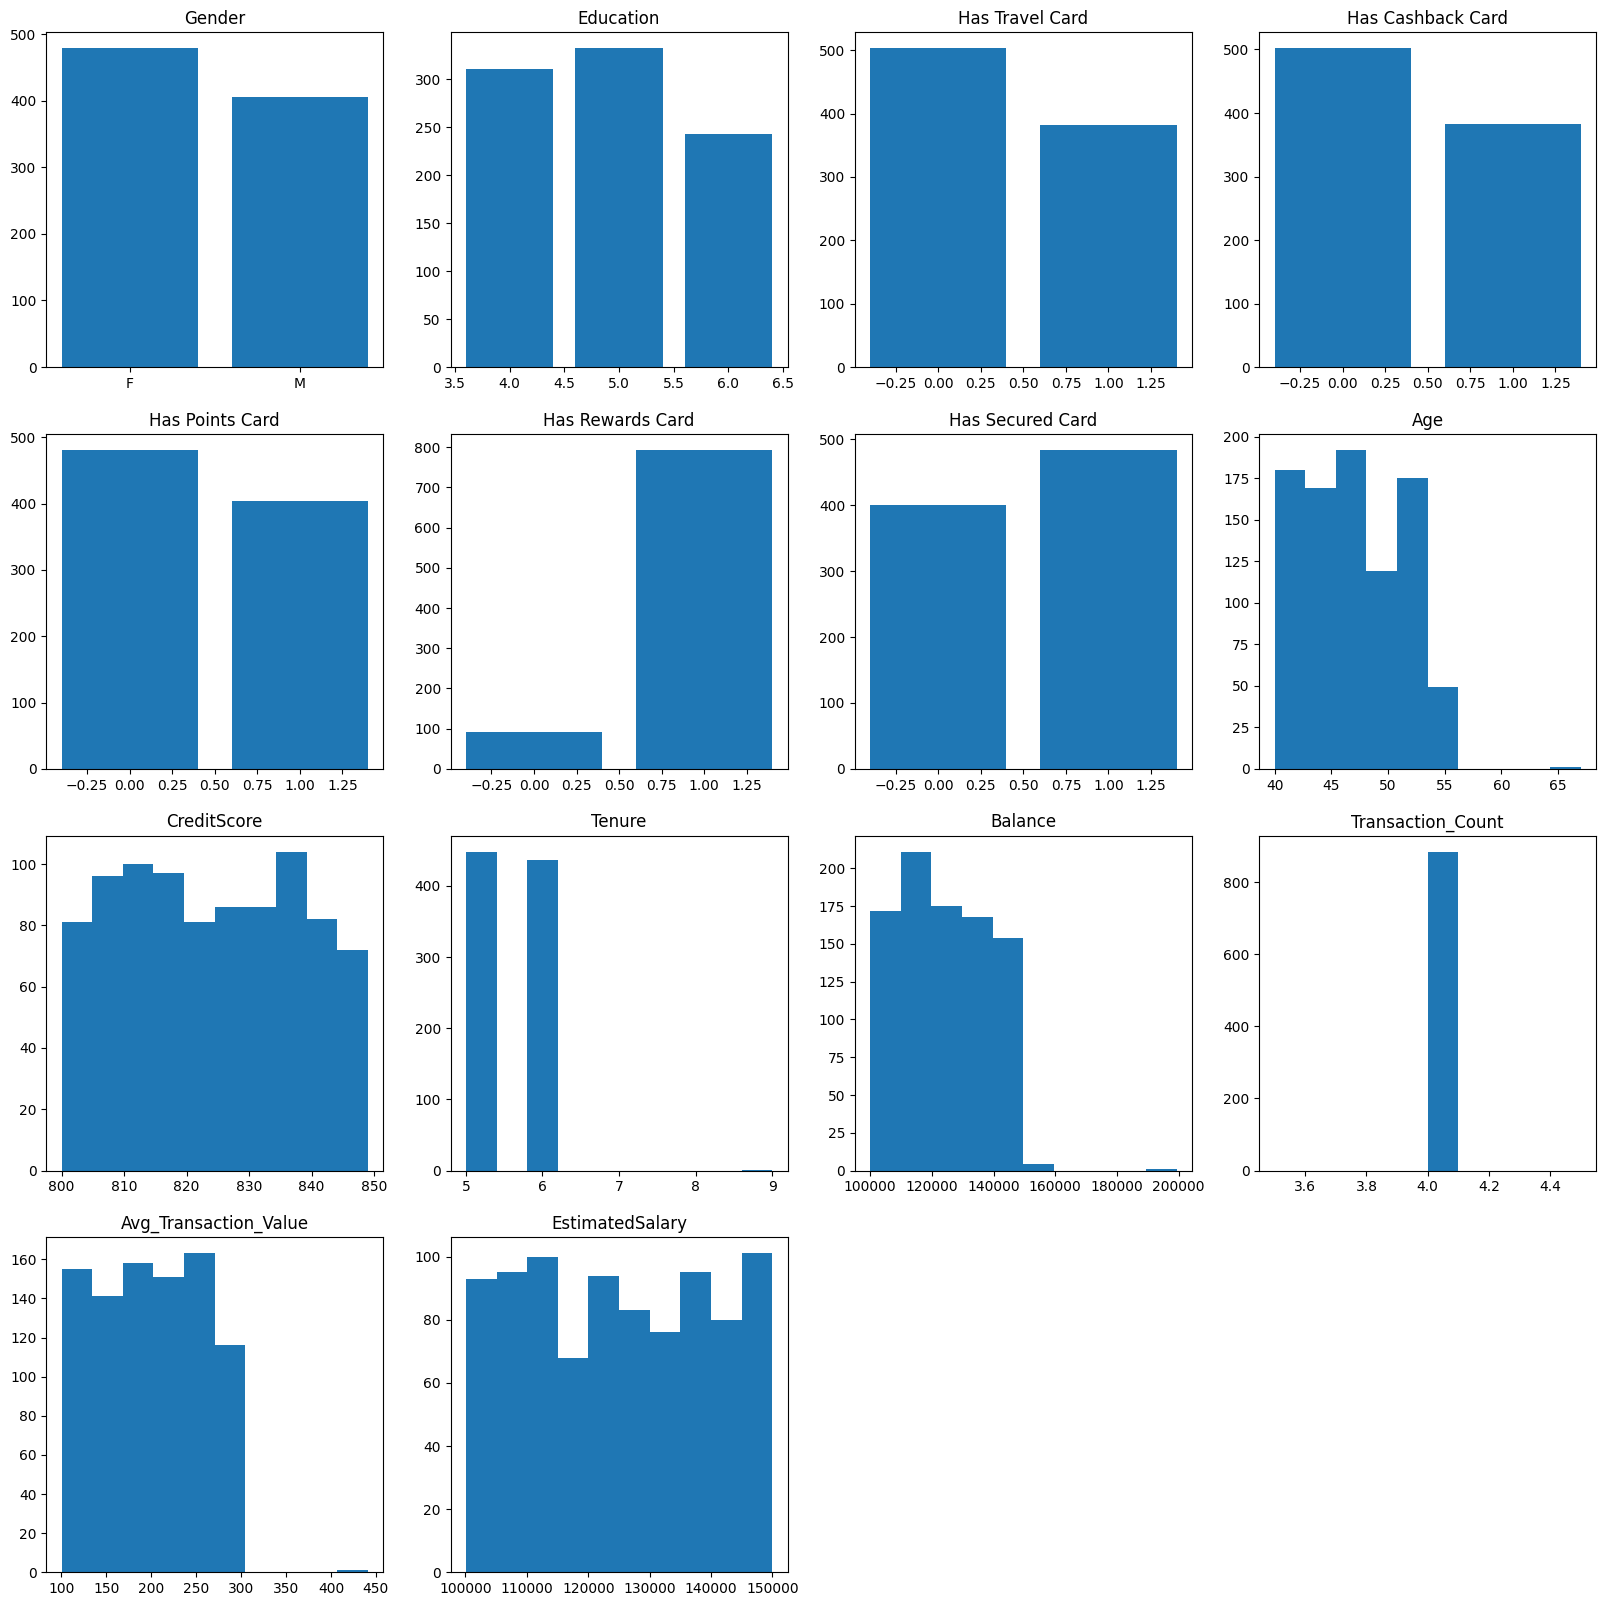

In [14]:
visualize_cluster(1)

# Cluster 2: Big Spenders

- Members of this cluster are older and have substantial savings, making them very high value members of the bank
- They tend to disproportionately prefer travel cards and points cards, which may be good target products for new members within this group
- They tend to have very long tenures, which magnifies their overall value


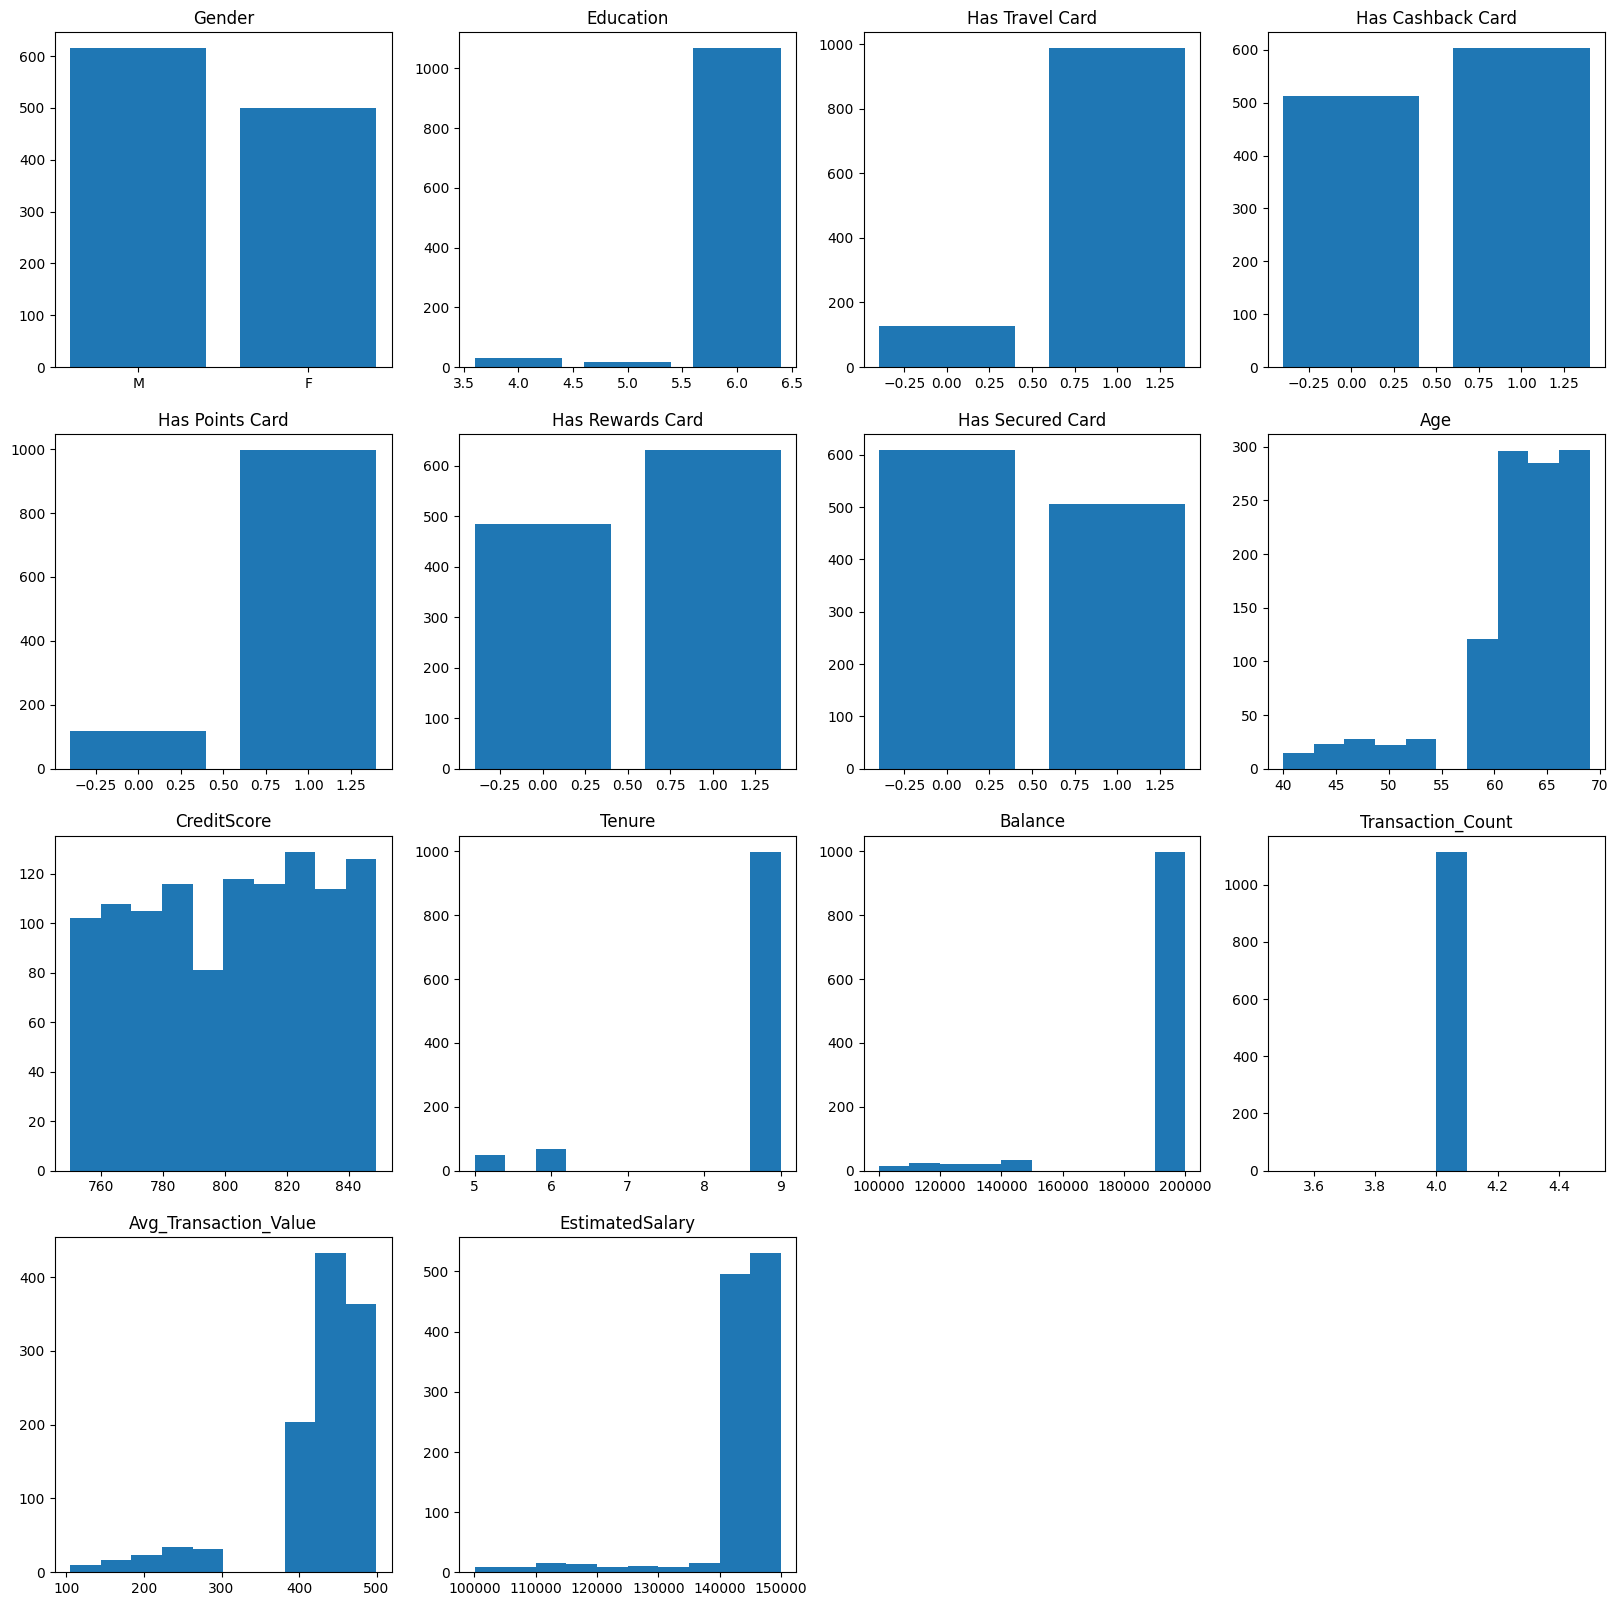

In [15]:
visualize_cluster(2)

# Assigning a cluster to a new user

Finally, if we have a new bank user, we might want to classify them into a cluster. 

# Example Usage of Customer Segments: Demographic-Based Product Recommendation

For example, perhaps we want to see which product to recommend to them.

In this case, we might want to exclude the product columns and just compute similarity based on the other columns (in some cases, we might include all columns)

In [19]:
new = np.array(
    [[(22-mins_dict["Age"])/(maxes_dict["Age"]-mins_dict["Age"]), 
      (300-mins_dict["CreditScore"])/(maxes_dict["CreditScore"]-mins_dict["CreditScore"]),  
      (2-mins_dict["Tenure"])/(maxes_dict["Tenure"]-mins_dict["Tenure"]),  
      (20000-mins_dict["Balance"])/(maxes_dict["Balance"]-mins_dict["Balance"]),  
      (1-mins_dict["Transaction_Count"])/(maxes_dict["Transaction_Count"]-mins_dict["Transaction_Count"]),
      (20-mins_dict["Avg_Transaction_Value"])/(maxes_dict["Avg_Transaction_Value"]-mins_dict["Avg_Transaction_Value"]),
      (30000-mins_dict["EstimatedSalary"])/(maxes_dict["EstimatedSalary"]-mins_dict["EstimatedSalary"]),
      0, 
      4, 
      0,
      0, 
      0,
      0,
      0]])
kmode.predict(new, categorical=[7, 8, 9, 10, 11, 12, 13])


array([0], dtype=uint16)

Here the user has been assigned to the "Young Penny Pinchers". This makes sense as she is a relatively young, low income person.

It might be a good idea to recommend cashback card to her, as people in her demographic seem to prefer it.